In [1]:
import sys
# sys.path.insert(0, '/home/jake/Repos/')
sys.path.insert(0, '/home/jake/Data/Repos/')
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt  # plotting
# the dataset
import datasets.mitchell.mtdots as datasets
# shifter model requirements
import neureye.models.encoders as encoders
import neureye.models.cores as cores
import neureye.models.readouts as readouts
import neureye.models.regularizers as regularizers
import neureye.models.utils as ut

In [1]:
import sys
# sys.path.insert(0, '/home/jake/Repos/')
sys.path.insert(0, '/home/jake/Data/Repos/')
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt  # plotting
# the dataset
import datasets.mitchell.mtdots as datasets
# shifter model requirements
import neureye.models.encoders as encoders
import neureye.models.cores as cores
import neureye.models.readouts as readouts
import neureye.models.regularizers as regularizers
import neureye.models.utils as ut

In [2]:
sess = '20190120'
data_dir = '/home/jake/Data/Datasets/MitchellV1FreeViewing/MT_RF/'
mt_ds = datasets.MTDotsDataset(sess, data_dir)
sample = mt_ds[:10]

In [3]:
class GLM(nn.Module):
def __init__(self, dims, NC, bias=True, gamma=1e-3, gamma_l1=1e-6):
super(GLM, self).__init__()
self.dims = dims
self.NI = np.prod(np.asarray(dims))
self.NC = NC
self.loss = nn.PoissonNLLLoss(log_input=False)
self.features = nn.Sequential(
nn.Flatten(),
nn.Linear(self.NI, NC, bias=bias),
nn.Softplus()
)
self.reg = regularizers.RegMats(dims=[dims[3], dims[1], dims[2]], type=['d2x', 'd2t'], amount=[.5, 1])
self.gamma = gamma
self.gamma_l1 = gamma_l1
self.initialize()
def forward(self, x):
return self.features(x)
def training_step(self, batch):
stim = batch['stim']
robs = batch['robs']
loss = self.loss(self.features(stim), robs)
w = self.features[1].weight
w = w.view([self.NC * self.dims[0]] + self.dims[1:]).permute((0, 3, 1 , 2))
reg = self.gamma*self.reg(w) + self.gamma_l1*w.abs().mean()
return {'loss': loss+reg, 'train_loss': loss, 'reg': reg}
def validation_step(self, batch):
stim = batch['stim']
robs = batch['robs']
loss = self.loss(self.features(stim), robs)
return {'loss': loss, 'val_loss': loss}
def initialize(self):
self.apply(self.init_)
def fit(self, ds, batch_size=500, max_epochs=100, version=None, save_path=os.path.join('.', 'checkpoints', 'mt_glm')):
from torch.utils.data import DataLoader, random_split
import neureye.models.trainers as trainers
lossfun = nn.PoissonNLLLoss(log_input=False, reduction='none')
ntrain = int(0.8*len(ds))
nval = len(ds)-ntrain
train_ds, val_ds = random_split(ds, [ntrain, nval])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.LBFGS(glm.parameters(), history_size=10,
max_iter=4,
line_search_fn="strong_wolfe")
early_stopping = trainers.EarlyStopping(patience=1)
trainer = trainers.Trainer(glm, optimizer=optimizer,
early_stopping=early_stopping, version=version,
dirpath=save_path,
max_epochs=max_epochs, optimize_graph=True)
trainer.fit(glm, train_dl, val_dl, seed=666)
sample = val_ds[:]
self.to('cpu')
yhat = self(sample['stim'])
val_loss = lossfun(yhat, sample['robs']).mean(dim=0)
return val_loss.detach().numpy()
@staticmethod
def init_(m):
if isinstance(m, nn.Linear):
nn.init.xavier_normal_(m.weight.data)
if m.bias is not None:
m.bias.data.fill_(0)

In [4]:
dims = [mt_ds.num_channels, mt_ds.NX, mt_ds.NY, mt_ds.num_lags]
batch_size = 10000 # Should be big (using L-BFGS), but set for your GPU size
save_path = os.path.join('.', 'checkpoints', 'mt_glm')
glm = GLM(dims, mt_ds.NC, gamma=2e-5, gamma_l1=1e-4) # glm with d2xt and l1
val_loss = glm.fit(mt_ds, batch_size=batch_size, version=None, save_path=save_path)
glm.gamma_l1=1e-1 # step up L1 penalty, see if it cleans up
val_loss = glm.fit(mt_ds, batch_size=batch_size, version=None, save_path=save_path)


GPU Available: True, GPU Used: True
Moving model to cuda:0
Validating ver=22: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, val_loss=0.27]

EarlyStopping counter: 1 out of 1
Early stopping
Done fitting

GPU Available: True, GPU Used: True
Moving model to cuda:0
Validating ver=23: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s, val_loss=0.266]

EarlyStopping counter: 1 out of 1
Early stopping
Done fitting


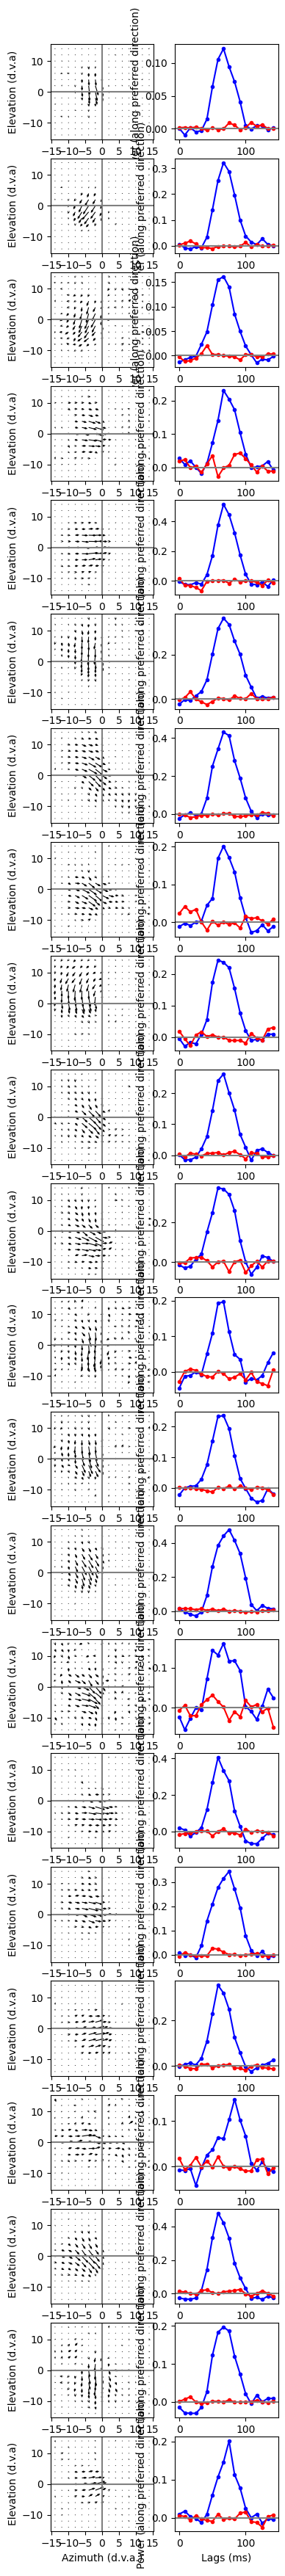

In [5]:
wtsAll = glm.features[1].weight.detach().cpu().numpy().T
NX = mt_ds.NX
NY = mt_ds.NY
num_lags = mt_ds.num_lags
xx = np.meshgrid(mt_ds.xax, mt_ds.yax)
plt.figure(figsize=(4, glm.NC*2))
for cc in range(glm.NC):
wtsFull = wtsAll[:,cc]
wts = np.reshape(wtsFull, glm.dims)
tpower = np.std(wts.reshape(-1,glm.dims[-1]), axis=0)
peak_lag = np.argmax(tpower)
I = wts[:,:,:,peak_lag]
dx = I[0, :,:]
dy = I[1, :,:]
# plt.figure(figsize=(8,4))
# plt.tight_layout()
ax = plt.subplot(glm.NC,2,cc*2+1)
amp = np.hypot(dx, dy)
peak_space = np.where(amp==np.max(amp))
min_space = np.where(amp==np.min(amp))
plt.quiver(xx[0]-np.mean(xx[0]), xx[1]-np.mean(xx[1]), dx/np.max(amp), dy/np.max(amp), # np.arctan2(dx, dy)/np.pi*180, cmap=plt.cm.v  ,
pivot='tail',units='width', width=.008,
scale=10, headwidth=2.5, headlength=2.5)
plt.axhline(0, color='gray', )
plt.axvline(0, color='gray')
plt.xlabel('Azimuth (d.v.a.)')
plt.ylabel('Elevation (d.v.a)')
plt.xticks(np.arange(-15,18,5))
ax2 = plt.subplot(glm.NC,2,cc*2+2)
# w = wts.transpose((1,2,0))
amp /= np.sum(amp)
muw = np.array( (dx.flatten() @ amp.flatten(), dy.flatten() @ amp.flatten()))
muw /= np.hypot(muw[0], muw[1])
tpeak =  wts[0,peak_space[0],peak_space[1],:].flatten()*muw[0] + wts[1, peak_space[0],peak_space[1],:].flatten()*muw[1]
tmin =  wts[0,min_space[0],min_space[1],:].flatten()*muw[0] + wts[1, min_space[0],min_space[1],:].flatten()*muw[1]
lags = np.arange(0, num_lags, 1)*1000/120
plt.plot(lags, tpeak, '-o', color='b', ms=3)
plt.plot(lags, tmin, '-o', color='r', ms=3)
plt.xlabel('Lags (ms)')
plt.ylabel('Power (along preferred direction)')
plt.axhline(0, color='gray')
# f = plt.xticks(np.arange(0,200,50))
# plt.show()
plt.show()